# Qui êtes-vous ?

<div class="alert alert-block alert-info">
Écrire ci-dessous votre nom, prénom et numéro étudiant :
</div>

| Nom       | Prénom  | N°Étudiant |
|-----------|---------|------------|
| VIN       | Charles | 21216136   |
| DELEFOSSE | Aymeric | 21213744   |



# TME 10- LIME / SHAP


<div class="alert alert-block alert-warning">
L'objet de ce TME est de tester les algorithmes LIME et SHAP sur des tâches de classification assez simple.
</div>


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## 1 - Préparation du dataset

<div class="alert alert-block alert-warning">
Utiliser le dataset <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI ML Breast Cancer Wisconsin (Diagnostic)</a>, comme dans le TME 3 et apprendre dessus un modèle linéaire de régression logistique
</div>


In [2]:
breast_cancer = datasets.load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer.data, breast_cancer.target, test_size=0.25, random_state=42
)
feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

logreg = LogisticRegression(max_iter=2500)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("=" * 50)
print(f"Accuracy = {(y_pred == y_test).sum() / len(y_test):.4f}")
print("=" * 50)

Accuracy = 0.9650


In [3]:
(breast_cancer.target == 1).sum()

357

In [4]:
breast_cancer.target_names

array(['malignant', 'benign'], dtype='<U9')

## 2- Explication avec SHAP

<div class="alert alert-block alert-warning">
Nous allons étudier une explication donnée par SHAP.
</div>


<div class = "alert alert-block alert-info">
    Q2.1 - Exécuter le bloc ci-dessous pour obtenir les explications globales de SHAP. Commentez.
</div>


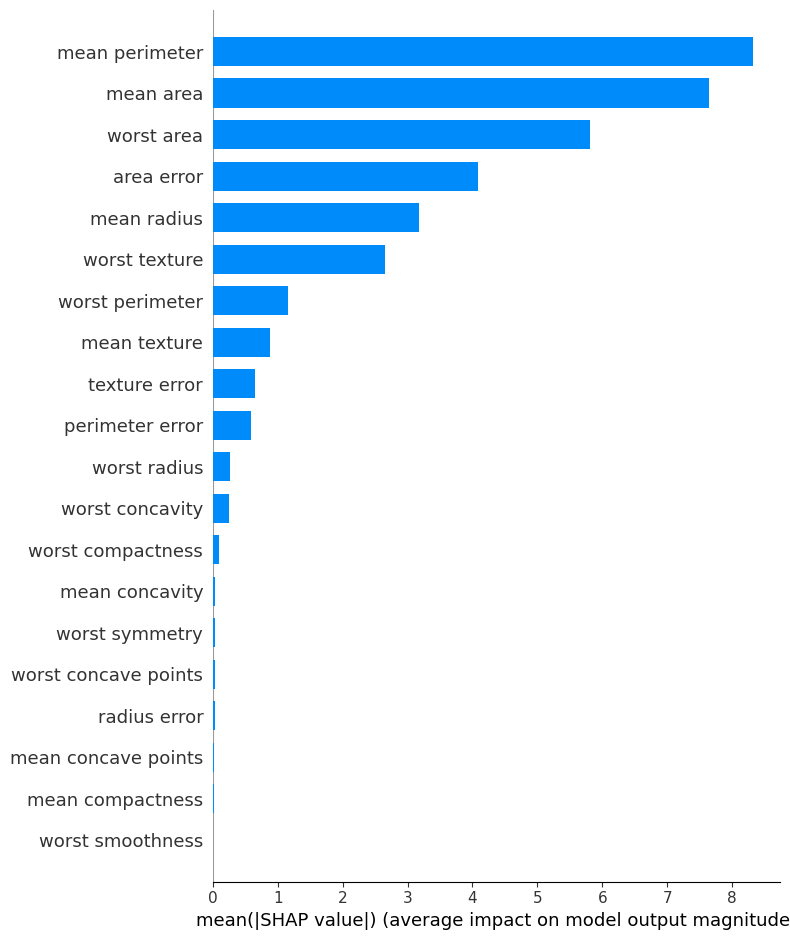

In [5]:
explainer = shap.LinearExplainer(logreg, X_train, feature_names=feature_names)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names)

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">
    <strong>Commentaire :</strong>

Les valeurs sur l'axe des abscisses représentent la valeur absolue moyenne de SHAP pour chaque caractéristique dans toutes les instances de l'ensemble de test. Plus la valeur est élevée, plus l'impact de cette caractéristique sur les résultats du modèle est important. Le diagramme à barres nous permet donc de déduire que :

- `mean perimeter` a l'impact moyen le plus élevé sur les résultats du modèle. Cela suggère que le périmètre moyen d'une zone tumorale a une grande influence sur les prédictions du modèle, ce qui est probablement en corrélation avec la classification des tumeurs malignes ou bénignes.
- Les caractéristiques `mean area` et `worst area` ont également un impact significatif, ce qui est logique puisqu'elles sont liées à la taille de la tumeur, qui sont essentielles pour diagnostiquer le cancer du sein.
- Les caractéristiques telles que `area error`, `mean radius`, `worst texture`, `mean texture`, `texture error` et `permimeter error` ont un impact modéré.
- Les caractéristiques ayant le moins d'impact sur les résultats du modèle sont `worst radius`, `worst concavity` et `worst compactness` (et toutes les caractéristiques suivantes).

Cependant, ce graphique de synthèse ne nous indique pas la direction de l'impact (si la caractéristique augmente ou diminue la probabilité que le modèle prédise une classe), mais plutôt l'ampleur des contributions des caractéristiques à la sortie du modèle. Pour cela, il faut utiliser un autre type de diagramme SHAP, comme le diagramme beeswarm ou le diagramme de décision, qui montre les valeurs SHAP individuelles pour chaque instance.

De plus, une deuxième remarque est, à quel point la corrélation entre plusieurs caractéristiques rend la valeur de SHAP similaire ? On peut effectivement penser que toutes les caractéristiques liés à la taille (`perimeter`, `area`) sont corrélées entre elles. Les valeurs de Shapley ne supposent pas l'indépendance. Mais, à cause du coût de calcul lié, il est courant de supposer l'indépendance, même si c'est en pratique très peu le cas (approximation Kernel SHAP).

Il est également important de noter que les caractéristiques ayant un faible impact sur le modèle peuvent néanmoins être importantes ; elles peuvent simplement avoir un rôle plus nuancé ou interagir avec d'autres caractéristiques d'une manière qui n'est pas prise en compte par les seules valeurs moyennes du SHAP.

Regardons la valeur moyenne non absolue de SHAP pour chaque caractéristique.

</div>


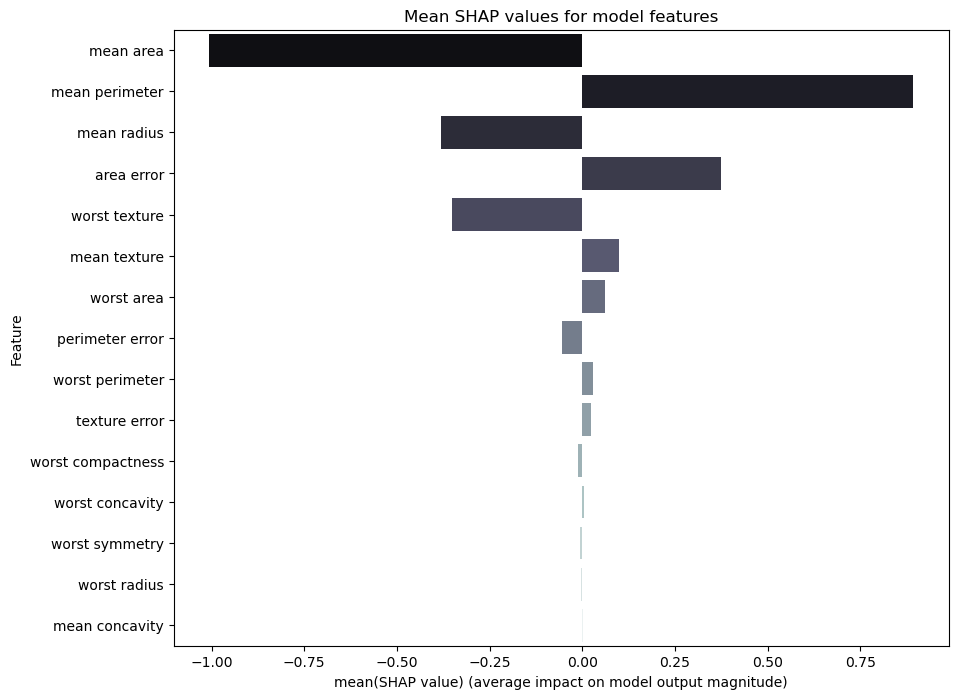

In [6]:
shap_mean_df = pd.DataFrame(
    {"Feature": feature_names, "mean(SHAP value)": shap_values.mean(0)}
)

# Sorting the DataFrame by the SHAP values
shap_mean_df = shap_mean_df.sort_values(
    by="mean(SHAP value)", ascending=False, key=lambda x: abs(x)
).head(15)

# Plotting the graph using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(
    x="mean(SHAP value)", y="Feature", hue="Feature", data=shap_mean_df, palette="bone"
)
plt.title("Mean SHAP values for model features")
plt.xlabel("mean(SHAP value) (average impact on model output magnitude)")
plt.ylabel("Feature")
shap_plot = plt.gca()


In [7]:
shap_mean_df

Feature  mean(SHAP value)
3           mean area         -1.007119
2      mean perimeter          0.893081
0         mean radius         -0.381157
13         area error          0.375323
21      worst texture         -0.351218
1        mean texture          0.099389
23         worst area          0.061440
12    perimeter error         -0.055101
22    worst perimeter          0.027802
11      texture error          0.023549
25  worst compactness         -0.011268
26    worst concavity          0.005266
28     worst symmetry         -0.005191
20       worst radius         -0.003517
6      mean concavity          0.002526

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">
    <strong>Commentaire :</strong>
    
- Les caractéristiques `mean perimeter` et `mean area` restent celles dont la valeur moyenne de SHAP est la plus élevée, ce qui indique leur forte influence sur les prédictions du modèle. 
    - Une valeur plus élevée pour `mean area` augmente fortement la probabilité que le modèle prédise la présence d'un cancer (0, "malin").
    - Une valeur plus élevée pour `mean perimeter` augmente fortement la probabilité que le modèle prédise l'absence d'un cancer (1, "bénin").
- La `worst area` n'apparait pas aussi haut que précédemment : de 6 en mean(|SHAP value|), on passe à 0.06 en mean(SHAP value), ce qui suggère qu'il y a autant de valeurs très positives ou très négatives en fonction des données (ce qu'on verra ensuite avec le beeswarm).

Ainsi, fournir les valeurs non absolues moyennes de SHAP permet de se faire une autre idée que le graphique précédent, mais n'est pas parfaite, au vu de comment SHAP fonctionne.

</div>


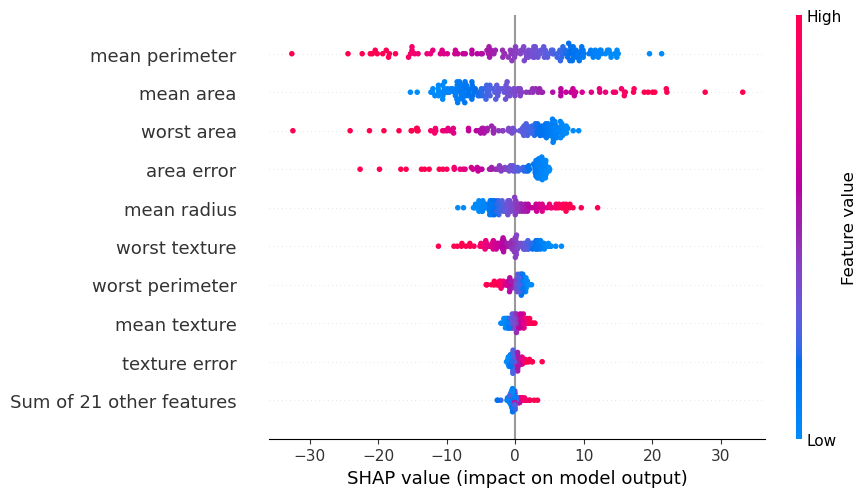

In [8]:
shap_values_ = explainer(X_test)
shap.plots.beeswarm(shap_values_)

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire :**

Ou, toujours en utilisant SHAP, on peut obtenir un graphe similaire mais beaucoup plus "joli" (le fameux beeswarm). La caractéristique distinctive de ce graphique est l'utilisation de points individuels pour représenter les valeurs spécifiques de chaque caractéristique pour les différentes prédictions. Chaque point correspond à une instance de la caractéristique dans le jeu de données, rendant ce graphique très informatif.

- Pour `mean perimeter`, `worst area`, `area error` et `worst texture`, des valeurs élevées contribuent significativement à augmenter la probabilité que le modèle prédise la présence de cancer, alors que des valeurs faibles tendent à prédire son absence.
- A l'inverse, pour `mean area` et `mean radius`, des valeurs élevées sont plutôt associées à l'absence de cancer, et des valeurs plus faibles à sa présence.
- Les caractéristiques listées après `worst perimeter` semblent avoir un impact minime sur les prédictions du modèle.

</div>


<div class = "alert alert-block alert-info">
    Q2.2 - Exécuter le bloc ci-dessous pour obtenir une explication locale avec SHAP du premier exemple de la base de test. Commentez.
</div>


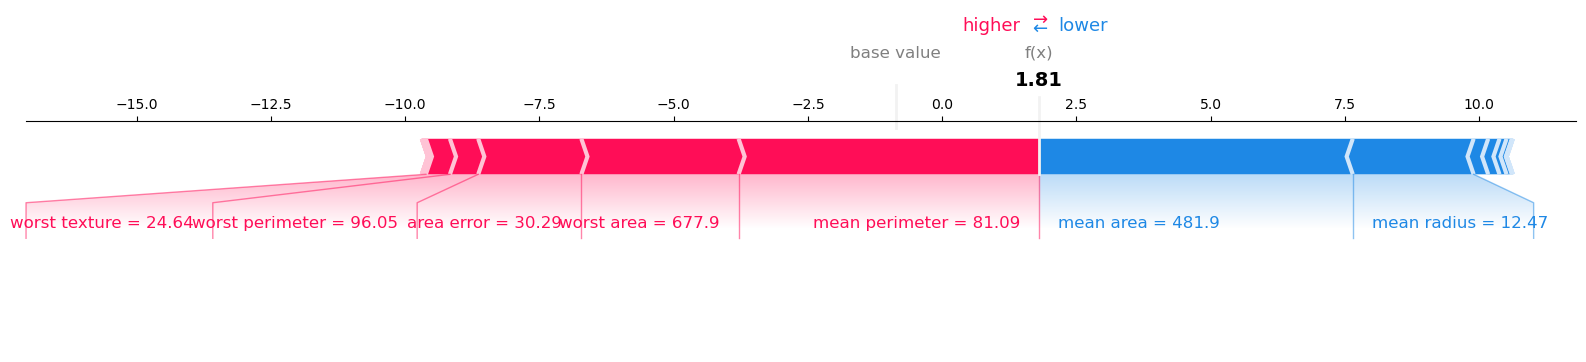

In [9]:
# shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_test[0, :],
    feature_names=feature_names,
    matplotlib=True,
)

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire :**

Le graphique SHAP "force plot" est une représentation visuelle de l'impact des caractéristiques sur la prédiction d'un modèle pour une instance spécifique. L'axe des abscisses représente une transformation log-odds de la probabilité prévue.

Voici un résumé des nos observations :

- $f(x)$ : Ce n'est pas la probabilité prédite $ p $ mais le logit de la probabilité, c'est-à-dire $ \log \left(\frac{p}{1-p}\right) $. Dans le cas de notre premier exemple de la base de test, la valeur de $ f(x) $ est positive, mais proche de 1, suggérant une forte incertitude concernant la classification de notre patient.

- **Mesure d'incertitude** : Ainsi, plus la valeur de $f(x)$ est éloignée de zéro, plus la prédiction du modèle est certaine. Une valeur fortement négative indiquerait une forte conviction que la classe est "bénigne", tandis qu'une valeur fortement positive indiquerait une forte conviction que la classe est "maligne".

- **<span style="color:#ff0d57">Caractéristiques positives (rose)</span>** : Les caractéristiques `worst texture`, `area error`, `worst perimeter`, `mean area`, et `worst area` ont un effet positif sur la prédiction du modèle, indiquant que les valeurs élevées pour ces caractéristiques sont associées à une prédiction de la classe "bénigne".

- **<span style="color:#1e88e5">Caractéristiques négatives (bleu)</span>** : Les caractéristiques `mean radius` et `worst radius` ont un effet négatif sur la prédiction du modèle, suggérant que les valeurs élevées pour ces caractéristiques sont associées à une prédiction de la classe "maligne".

- **Valeurs des caractéristiques** : Les nombres sur les barres indiquent les valeurs réelles des caractéristiques pour l'instance spécifique analysée. Ces valeurs sont utilisées pour calculer l'impact sur le logit de la probabilité.

Lors du TME, nous nous demandions qu'est-ce que la _base value_ (qui correspond à l'_expected value_) et à quoi correspond-elle. La _base value_ correspond à une valeur de prédiction d'un modèle sans caractéristiques (_feature-less model_), c'est-à-dire l'espérance de notre modèle, $\mathbb{E}[f(x)]$.

</div>


<div class = "alert alert-block alert-info">
    Q2.3 - Comparer avec l'exemple suivant de la base de test.
</div>


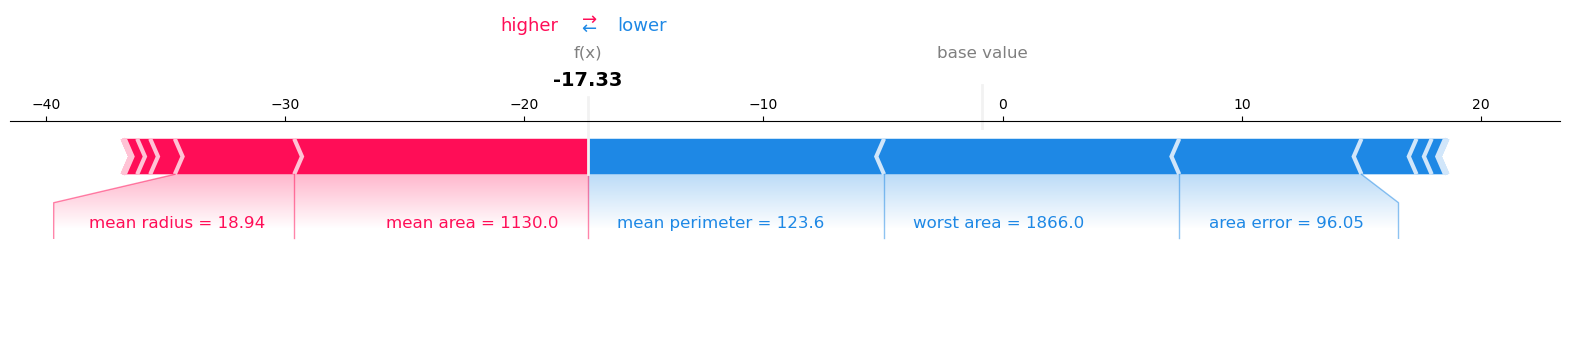

In [10]:
shap.force_plot(
    explainer.expected_value,
    shap_values[1, :],
    X_test[1, :],
    feature_names=feature_names,
    matplotlib=True,
)

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire :**

Dans ce cas, la sortie du modèle est beaucoup plus négative (-20.47), ce qui suggère une forte confiance que l'instance appartient à la classe avec la probabilité $ p $ proche de 0 ("bénigne"). Ce qui est particulièrement intéressant ici, c'est la magnitude extrême de $ f(x) $ comparée à l'autre exemple. Cela souligne l'importance de comprendre comment les valeurs individuelles de chaque caractéristique contribuent à la prédiction finale dans le contexte spécifique des données sur lesquelles le modèle a été formé.

Comparons cela avec l'analyse précédente :

- Dans le premier exemple, $ f(x) $ était positif, mais proche de 0, suggérant une incertitude mais avec un penchant vers la classe "maligne". Ici, la valeur négative élevée de $ f(x) $ suggère le contraire.
- Les caractéristiques qui ont le plus d'impact sur la prédiction sont toujours représentées par la longueur des barres, mais cette fois, elles poussent la prédiction dans la direction opposée.
- `mean perimeter`, `mean radius`, et `worst radius` ont des contributions positives, ce qui signifie que ces trois caractéristiques "poussent" le modèle vers une prédiction "maligne".
- À l'inverse, `worst area`, `worst perimeter`, et `area error` poussent la prédiction dans une direction négative et contrebalancent les effets des autres caractéristiques.

Malgré les contributions positives des caractéristiques roses, la prédiction globale du modèle penche fortement vers la classe "bénigne". Cet exemple illustre la complexité de l'interprétation des modèles prédictifs, en particulier lorsqu'on utilise des outils d'explication tels que SHAP. Il est essentiel de bien comprendre la direction et la magnitude des contributions de chaque caractéristique pour interpréter correctement ces graphiques. Malgré la "beauté" de ce type de graphique, il y a besoin d'un temps d'apprentissage pour bien les lire...

</div>


## 3 - Expérimentations

<div class="alert alert-block alert-warning">
    <ul>
        <li> Comparer les résultats fournis par LIME et SHAP sur des données identiques et commenter les résultats</li>
        <li> Examiner les résultats par exemple sur les données half-moons dans un cas où une explication linéaire est inappropriée</li>
        <li> Générer d'autres explications globales avec SHAP</li>
        <li> Modifier votre propre implémentation de LIME pour utiliser le noyau SHAP et comparer au résultat fourni par SHAP [facultatif]</li>
    </ul>
</div>


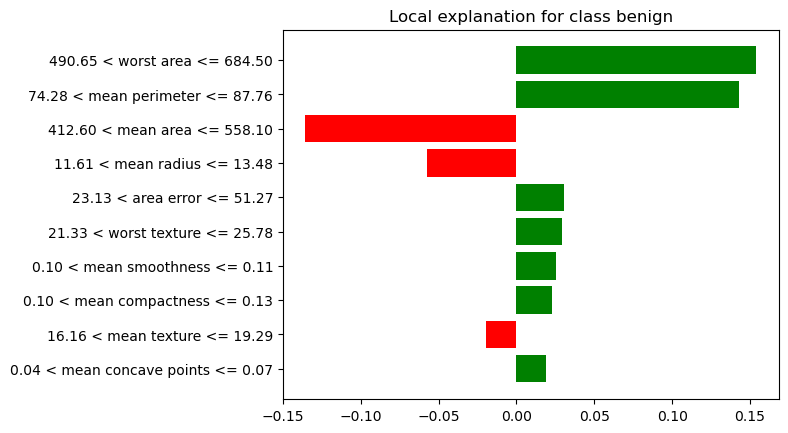

In [11]:
explainer_lime = LimeTabularExplainer(
    X_test,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode="classification",
)

exp = explainer_lime.explain_instance(X_test[0], logreg.predict_proba, num_features=10)
exp.as_pyplot_figure()
plt.show()

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire LIME :**

- Les <span style="color:#ff0000">barres rouges</span> indiquent les caractéristiques qui contribuent à une classification de la classe "maligne" et les <span style="color:#008000">barres vertes</span> indiquent celles qui contribuent à une classification de la classe "bénigne".
- La largeur des barres reflète l'importance de la contribution de la caractéristique à la prédiction de la classe. Par exemple, une grande barre verte pour `worst area` indique que, pour cette instance, lorsque la valeur de `worst area` se situe entre 490.65 et 684.50, cela diminue fortement la probabilité d'une prédiction de cancer (suggérant que c'est bénin).

</div>


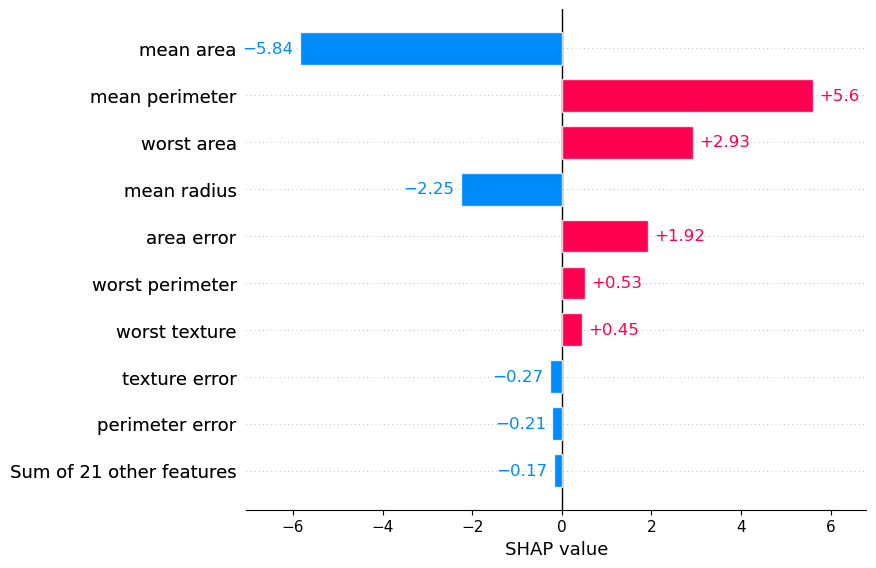

In [12]:
shap.plots.bar(shap_values_[0], max_display=10)

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire SHAP :**

- Les <span style="color:#008bfb">barres bleues</span> indiquent les caractéristiques qui contribuent négativement à la prédiction (vers la classe "maligne"), et les <span style="color:#ff0051">barres rouges</span> indiquent celles qui contribuent positivement (vers la classe "bénigne").
- La longueur des barres et la valeur SHAP associée montrent la force de cette contribution. Par exemple, `mean area` a une contribution négative importante, ce qui signifie que, pour cette instance, une grande valeur de `mean area` pousse la prédiction vers la classe 0.

</div>

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Comparaison LIME vs SHAP :**

Il y a une cohérence globale dans l'explication des caractéristiques par LIME et SHAP :

- `worst area`, `mean perimeter`, `worst texture`, `area error` et `worst perimeter` contribuent toutes à classifier la donnée vers la classe positive. La différence est à quel degré elles le font, en fonction de l'explication donnée par SHAP ou par LIME. Par exemple, `worst area` a une importance plus grande dans LIME que dans SHAP.
- `mean area` et `mean radius` sont toutes les deux des caractéristiques communes de nos deux explications, et contribuent à classifier la donnée vers la classe négative. Ici, contrairement aux caractéristiques précédentes, LIME et SHAP attribuent un poids similaire.
- Il y a des caractéristiques dans l'explication de LIME qui ne sont pas dans l'explication de SHAP, et vice-versa.

La différence clé est que SHAP prend en compte les interactions entre les caractéristiques et attribue des valeurs SHAP basées sur une répartition équitable des contributions, alors que LIME génère une explication locale en approximant le modèle par un modèle linéaire simplifié.

</div>


### Corrélation et SHAP

(Sur le dataset Breast Cancer)


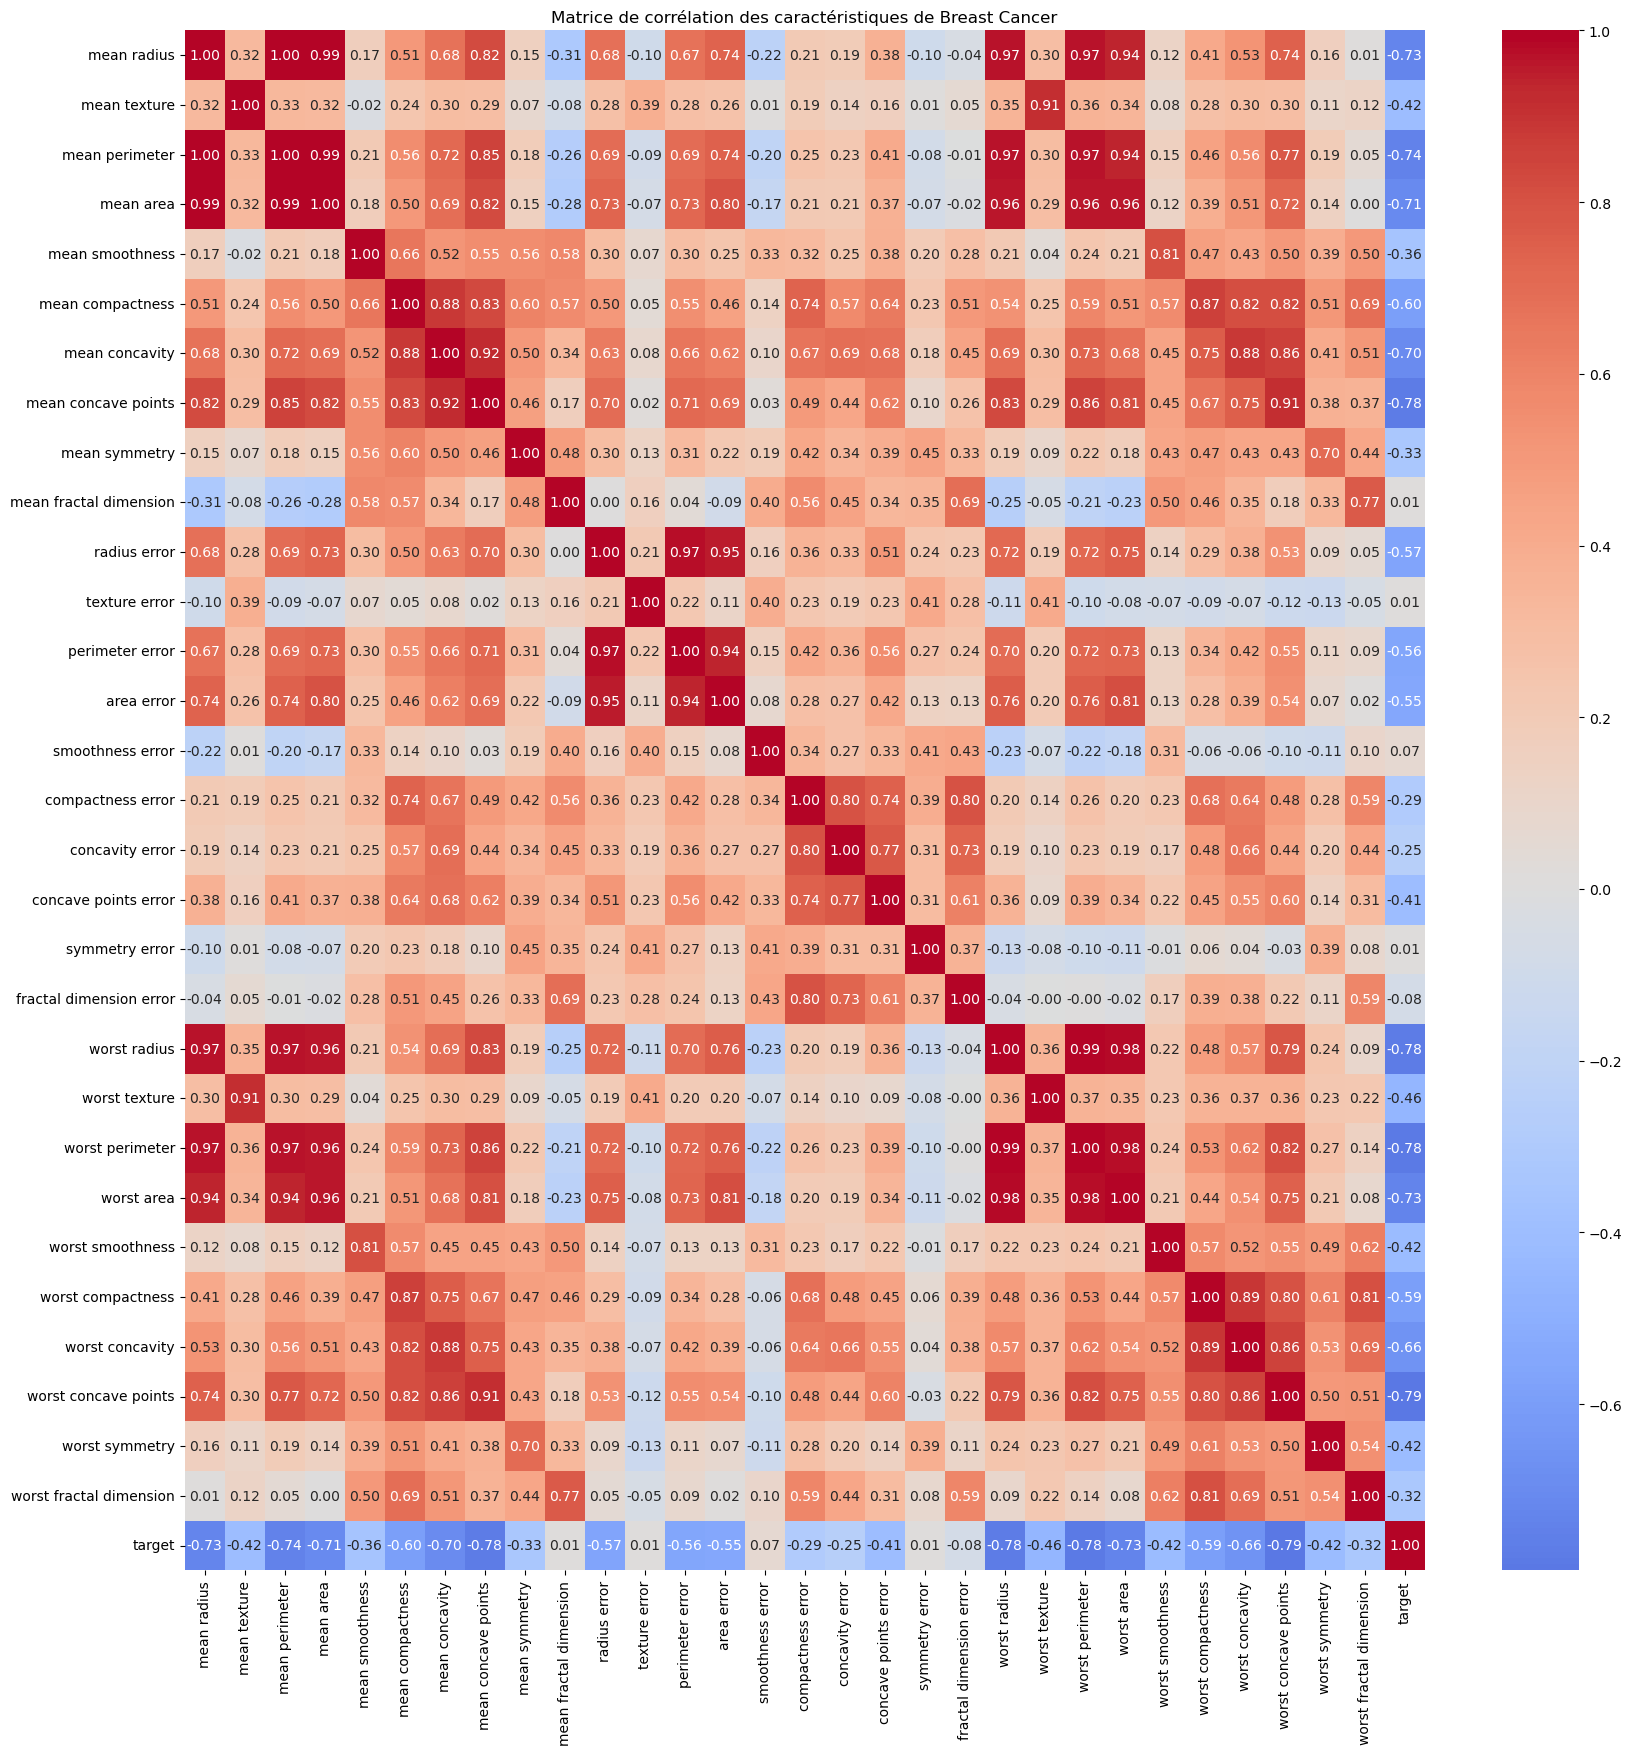

In [13]:
X = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
y = pd.Series(breast_cancer.target, name="target")

# Concaténer les features et la cible pour calculer la corrélation
df = pd.concat([X, y], axis=1)

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matrice de corrélation des caractéristiques de Breast Cancer")
plt.show()


En fait je suis pas sur de voir comment bien montrer une potentielle corrélation entre les features correlées et SHAP. :/


### Données non linéaires


In [14]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_boundaries(X, y, clf, ax=None):
    """Plot the data and the decision boundary resulting from a classifier."""
    if ax is None:
        fig, ax = plt.subplots()
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5, cmap=plt.cm.RdBu)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

Accuracy = 0.9760


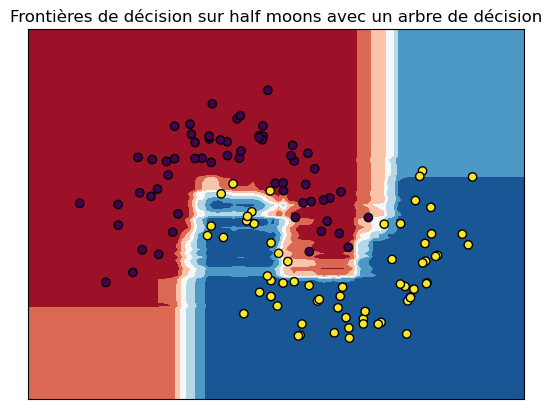

In [15]:
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

# Générer des données half-moons
X, y = make_moons(n_samples=500, noise=0.20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Entraîner un classificateur
tree = RandomForestClassifier(n_estimators=100, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("=" * 50)
print(f"Accuracy = {(y_pred == y_test).sum() / len(y_test):.4f}")
print("=" * 50)

plot_boundaries(X_test, y_test, tree)
plt.title("Frontières de décision sur half moons avec un arbre de décision")
plt.show()

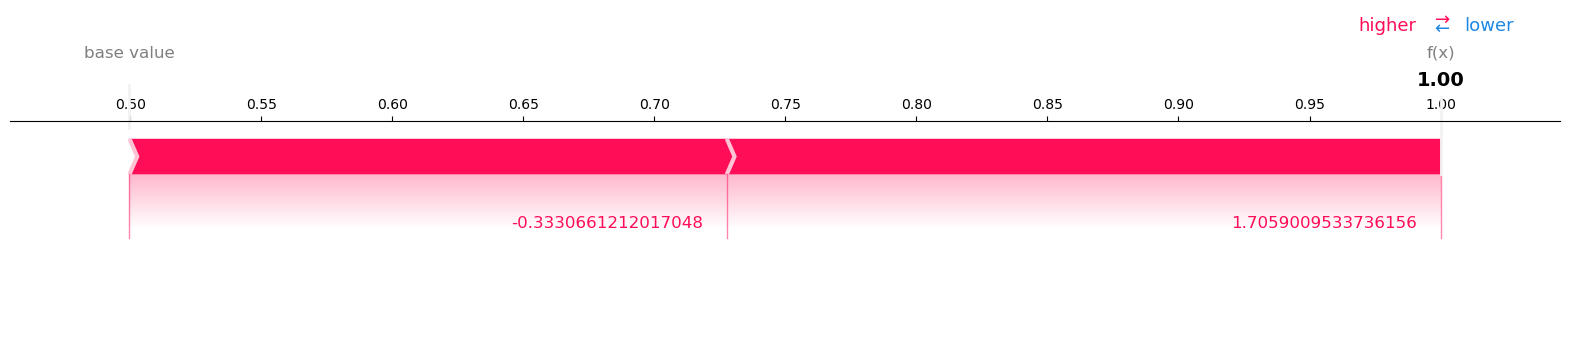

In [16]:
# SHAP
shap_explainer = shap.TreeExplainer(tree, feature_names=["feature 1", "feature 2"])
shap_values = shap_explainer.shap_values(X_test)

# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=["feature 1", "feature 2"],
    class_names=["class 0", "class 1"],
    discretize_continuous=True,
)

# Sélectionner une instance à expliquer
i = 10
shap_explanation = shap_explainer.shap_values(X_test[i])
lime_explanation = lime_explainer.explain_instance(
    X_test[i], tree.predict_proba, num_features=2
)

# Afficher les résultats SHAP
shap.force_plot(
    shap_explainer.expected_value[1], shap_explanation[1], X_test[i], matplotlib=True
)
# Afficher les résultats LIME
lime_explanation.show_in_notebook()


lol, on trouve les même résultats ? jspquoi dire là, pas très intéressant car on n'a que 2 features


## 4 - Données textuelles [facultatif]

<div class="alert alert-block alert-warning">
    Apprendre un modèle de classification random forest sur les données <code>fetch_20newsgroups</code> puis utiliser LIME et SHAP pour obtenir des explications sur la classification d'exemples.
</div>


<div class = "alert alert-block alert-info">
À l'aide de la <a href="https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py">documentation du dataset fetch_20newsgroups</a>,  apprendre un modèle random forest de classification bi-classe de texte.
</div>


In [17]:
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)

categories = ["sci.space", "sci.crypt"]
newsgroups_train = datasets.fetch_20newsgroups(
    subset="train", categories=categories, remove=("headers", "footers", "quotes")
)
newsgroups_test = datasets.fetch_20newsgroups(
    subset="test", categories=categories, remove=("headers", "footers", "quotes")
)


On utilise des **stopwords** afin d'éliminer les mots courants (tels que _is_, _this_, etc.) qui risquerait d'introduire du bruit dans l'analyse textuelle et afin d'améliorer notre classifieur.


In [35]:
vectorizer = TfidfVectorizer(lowercase=False, stop_words=stopwords.words("english"))
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = RandomForestClassifier(random_state=42)
rf.fit(train_vectors, newsgroups_train.target)


RandomForestClassifier(random_state=42)

In [19]:
y_pred = rf.predict(test_vectors)
accuracy = accuracy_score(newsgroups_test.target, y_pred)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(
    newsgroups_test.target, y_pred, target_names=newsgroups_test.target_names
)
print("Classification Report:\n", report)


Accuracy: 0.88
Classification Report:
               precision    recall  f1-score   support

   sci.crypt       0.95      0.80      0.87       396
   sci.space       0.83      0.96      0.89       394

    accuracy                           0.88       790
   macro avg       0.89      0.88      0.88       790
weighted avg       0.89      0.88      0.88       790



[Text(0, 0, 'sci.space'), Text(0, 1, 'sci.crypt')]

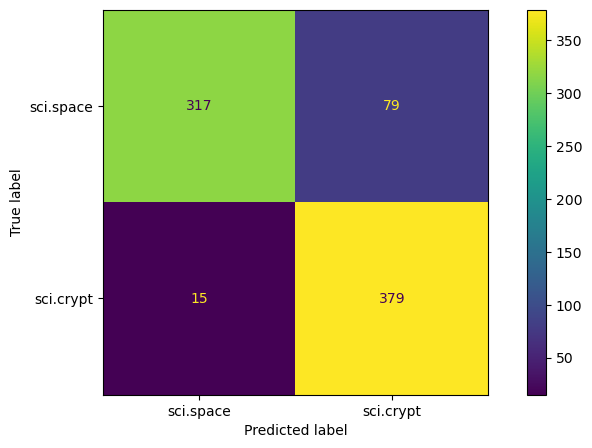

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(newsgroups_test.target, y_pred, ax=ax)
ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)


<div class = "alert alert-block alert-info">
Utilisez LIME et SHAP pour obtenir des explications sur les prédictions obtenues sur des exemples.
    </div>


LIME : facile, très bien documenté pour les données textes.


In [117]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

c = make_pipeline(vectorizer, rf)
explainer_lime = LimeTextExplainer(class_names=newsgroups_test.target_names)


SHAP : mal documenté pour des données textes entrainés sur des classifieurs classiques...


In [137]:
feature_names = vectorizer.get_feature_names_out()
# Transformer les données vectorisés en DataFrame pour SHAP
train_df = pd.DataFrame(train_vectors.todense(), columns=feature_names)
test_df = pd.DataFrame(test_vectors.todense(), columns=feature_names)
train_df.shape, test_df.shape


((1188, 26515), (790, 26515))

In [119]:
explainer_shap = shap.TreeExplainer(rf, train_df, feature_names=feature_names)
shap_values = explainer.shap_values(test_df)
shap_values_ = explainer(test_df)


 99%|===================| 1572/1580 [01:16<00:00]        

**Première remarque :** il faut un peu plus d'1 minute (soit environ 2 minutes 30 pour calculer la cellule du dessus) pour calculer les valeurs de Shapley sur les données de test, qui fait écho à la lenteur de SHAP, à cause de son approche "globale". Après, sachant qu'il y a 26515 caractéristiques (par 1188 données de train et 790 données de test) (taille du vocabulaire composant notre Bag of Words), cela reste acceptable.


In [146]:
idx = 69
exp = explainer_lime.explain_instance(
    newsgroups_test.data[idx], c.predict_proba, num_features=10
)
print(f"Document id: {idx}")
print(
    f"Probability(sci.crypt) = {1 - c.predict_proba([newsgroups_test.data[idx]])[0, 1]:.4f}"
)
print(f"True class: {newsgroups_test.target_names[newsgroups_test.target[idx]]}")
exp.show_in_notebook()


Document id: 69
Probability(sci.crypt) = 0.8200
True class: sci.crypt


In [139]:
exp.as_list()

[('Clipper', -0.10702311101958888),
 ('keys', -0.09097775004187914),
 ('phone', -0.08634519038338238),
 ('number', -0.03761048522391806),
 ('serial', -0.03254484891431433),
 ('The', 0.028783046354091235),
 ('get', 0.02555206514012375),
 ('care', -0.02514335297426482),
 ('warrant', -0.02102253070037969),
 ('using', -0.016038180792084415)]

<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire LIME :**

La visualisation LIME montre que les termes "Clipper", "keys", "phone", "number", et "serial" sont les plus influents pour classer un document spécifique comme relevant de la catégorie `sci.crypt`. Les mots "care", "warrant", et "using" ont également une contribution positive, bien que moins significative. Cependant, les mots "The" et "get" ont une influence négative, favorisant à tort la classification dans la catégorie `sci.space`. Malgré cette influence négative, elle est insuffisante pour renverser la tendance imposée par les termes clés positifs.

</div>


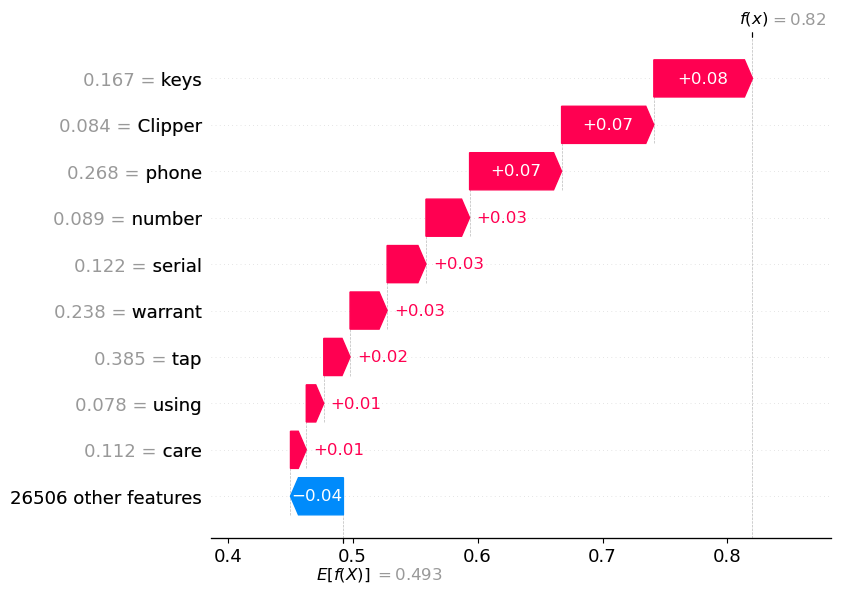

In [135]:
class_predite = y_pred[idx]
shap.plots.waterfall(shap_values_[idx, :, class_predite])


<div style="padding: 10px; border-left: 6px solid #2196F3; margin-bottom: 15px;">

**Commentaire SHAP :**

Nous avons choisi d'utiliser le plot "waterfall" pour la visualisation. Il est similaire au "force plot" mais affiche les caractéristiques d'une manière cascadée. Cela rend le graphique plus lisible, compte tenu de la forme de nos caractéristiques. De plus, on remarque que c'est bien la probabilité d'obtenir la classe qui est affichée. Ici, $ P(\text{sci.crypt}) = 0.82 $, comme avec LIME (normal, vu que l'on travaille sur le même classifieur).

_Note :_ Dans SHAP, on doit préciser, en plus de l'exemple, quelle classe on souhaite expliquer, c'est-à-dire la classe prédite par le classifieur ; ici 0 (`sci.crypt`). On peut, si on le souhaite, expliquer l'autre classe, mais, ce n'est généralement pas ce que l'on veut faire en explicabilité.

Ainsi, le graphique confirme que "keys" est le terme le plus déterminant pour la classification en `sci.crypt`, suivi de près par "Clipper" et "phone". Des termes tels que "number", "serial", et "warrant" jouent également un rôle important. Les termes "tap", "using", et "care" apparaissent comme moins déterminants mais sont tout de même des indicateurs positifs de la classe `sci.crypt`. Il est intéressant de noter que SHAP attribue une importance relative légèrement différente à certains mots par rapport à LIME, mais les deux méthodes s'accordent globalement sur les caractéristiques les plus influentes. SHAP révèle également l'influence combinée des autres caractéristiques, montrant que leur contribution globale est mineure par rapport aux termes clés identifiés.

Les deux visualisations mettent en lumière les mots-clés influençant le modèle, mais la cohérence entre les deux méthodes renforce la confiance dans l'interprétation des caractéristiques importantes. Les différences dans l'ordre et l'importance des caractéristiques reflètent les nuances des deux méthodes d'explication. D'un côté, LIME fournit une approximation locale linéaire de la prédiction, qui peut être plus interprétable mais moins précise dans le cas de modèles non linéaires. De l'autre, SHAP offre une perspective basée sur la théorie des jeux et considère les contributions de toutes les caractéristiques ensemble, ce qui peut donner une vue plus globale mais potentiellement plus complexe à interpréter.

</div>


In [126]:
idx = -1
exp = explainer_lime.explain_instance(
    newsgroups_test.data[idx], c.predict_proba, num_features=6
)
print(f"Document id: {idx}")
print(f"Probability(sci.space) = {c.predict_proba([newsgroups_test.data[idx]])[0, 1]}")
print(f"True class: {categories[newsgroups_test.target[idx]]}")
exp.show_in_notebook()


Document id: -1
Probability(sci.crypt) = 0.5661673271194955
True class: sci.space


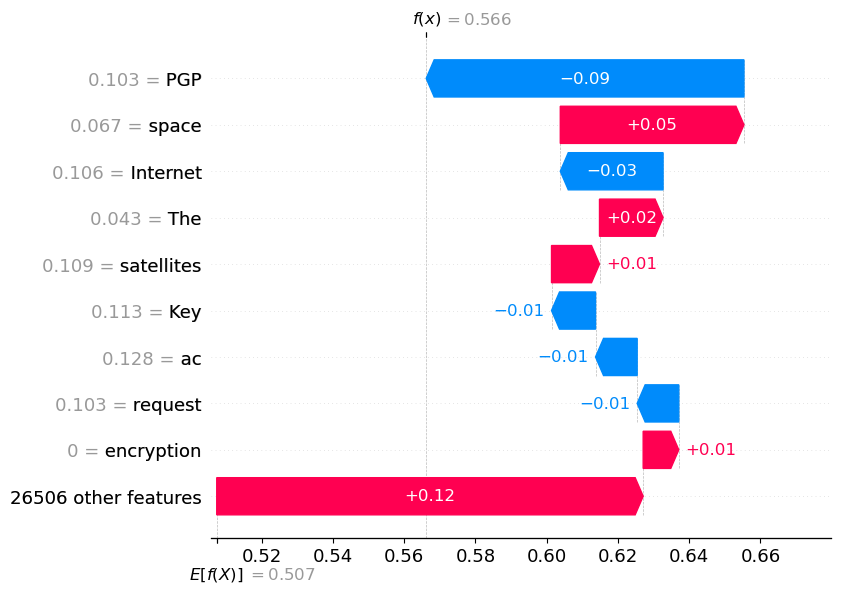

In [128]:
class_predite = y_pred[idx]
shap.plots.waterfall(shap_values_[idx, :, 1])


Par contre, contrairement à LIME, SHAP permet d'avoir une explication "globale" :


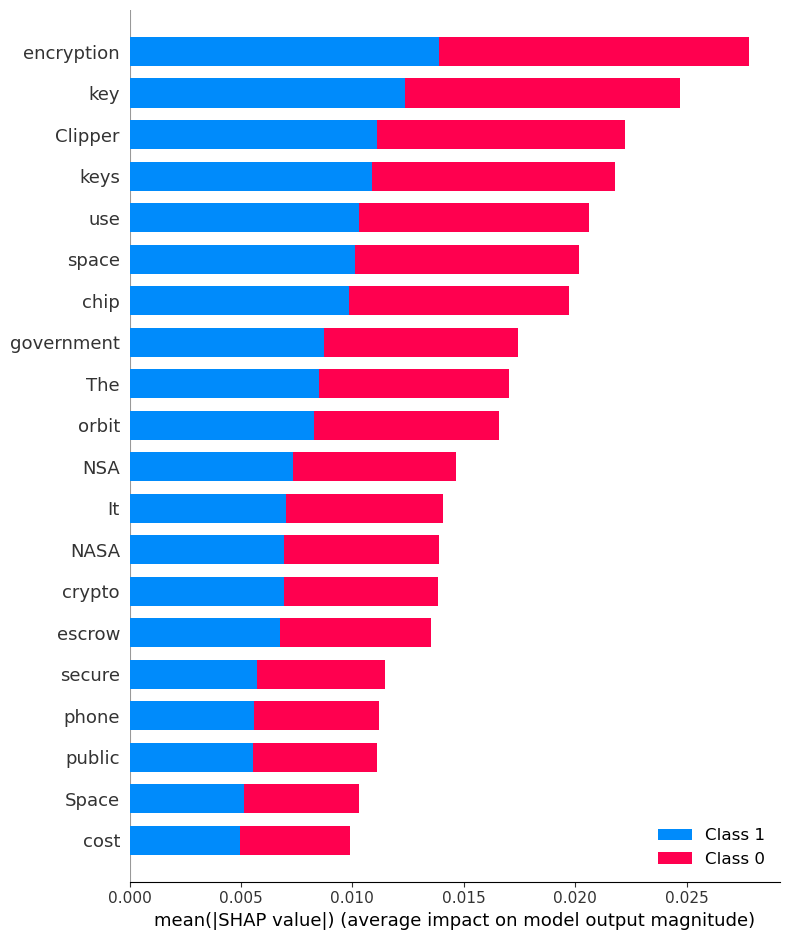

In [149]:
shap.summary_plot(shap_values, test_df, plot_type="bar", feature_names=feature_names)

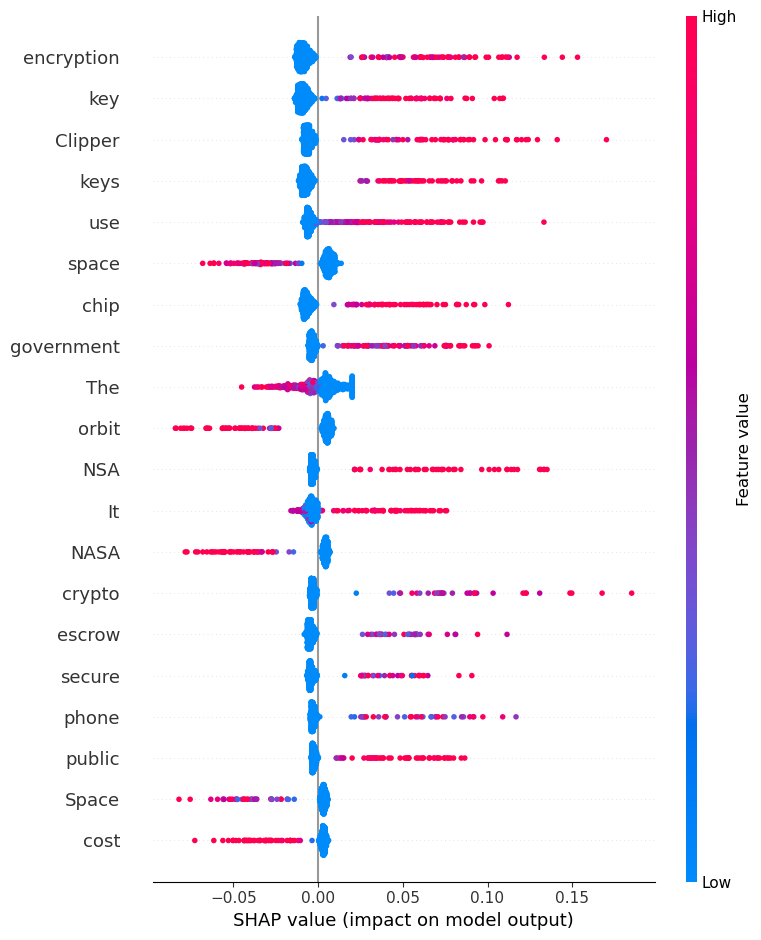

In [160]:
shap.summary_plot(shap_values[0], test_df, feature_names=feature_names)  # sci.space

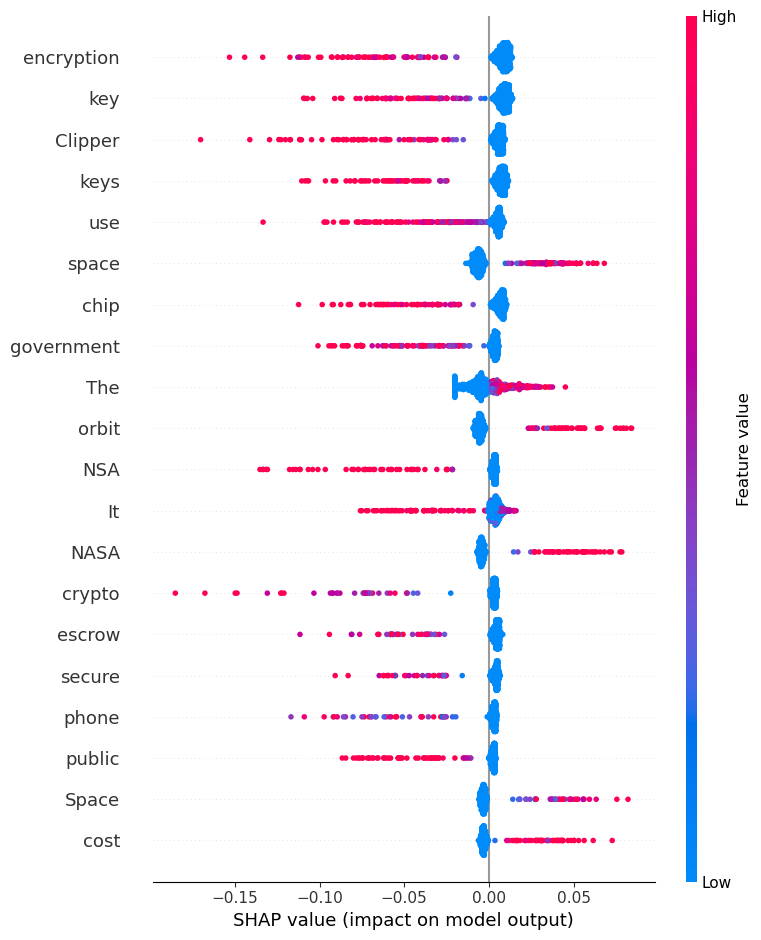

In [155]:
shap.summary_plot(shap_values[1], test_df, feature_names=feature_names)  # sci.crypt